In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import lingam

# sample data

In [35]:
# parameters
m = 6
p = 5
n = 1000
nb_gaussian_sources = 0
random_state = 42
rng = np.random.RandomState(random_state)

In [36]:
# function that samples data according to our model
# we use similar parameters as in Fig. 2 of the ShICA paper
def sample_data(m, p, n, nb_gaussian_sources=0, rng=None):
    # sources
    S_ng = rng.laplace(size=(p-nb_gaussian_sources, n))
    S_g = rng.normal(size=(nb_gaussian_sources, n))
    S = np.vstack((S_ng, S_g))

    # noise
    sigmas = np.ones((m, p)) * 1 / 2
    if nb_gaussian_sources != 0:
        sigmas[:, -nb_gaussian_sources:] = rng.uniform(size=(m, nb_gaussian_sources))
    N = rng.normal(scale=sigmas[:, :, np.newaxis], size=(m, p, n))

    # causal effect matrices
    B = rng.normal(size=(m, p, p))
    for i in range(m):
        B[i][np.triu_indices(p, k=0)] = 0  # set the strictly upper triangular part to 0
    
    # causal order
    P = np.eye(p)
    rng.shuffle(P)

    # mixing matrices
    A = P.T @ np.linalg.inv(np.eye(p) - B) @ P

    # observations
    X = np.array([Ai @ Si for Ai, Si in zip(A, S + N)])

    return X, P, B, A

In [37]:
# generate observations X, causal order P, and causal effects B
X, P, B, _ = sample_data(m, p, n, nb_gaussian_sources, rng)
true_order = np.argmax(P, axis=1)
X_reshaped = X.reshape(m, n, p)

# Multi Group DirectLiNGAM

In [38]:
# perform Multi Group DirectLiNGAM
model = lingam.MultiGroupDirectLiNGAM()
model.fit(list(X_reshaped))

In [39]:
# causal order P
order_estimate = model.causal_order_
P_estimate = np.eye(p)[order_estimate]

# causal effect matrices B
B_estimates = np.array(model.adjacency_matrices_)
B_tilde = P @ B_estimates @ P.T

# errors

In [40]:
# errors
error_P = 1 - (P_estimate == P).all()
error_B = np.mean((B_tilde - B) ** 2)

if error_P:
    print("The causal order P is not retrieved.")
else:
    print("The causal order P is retrieved!")
print(f"Error on causal effect matrices B : {error_B}")

The causal order P is not retrieved.
Error on causal effect matrices B : 0.4236941677909241


# plot

In [41]:
# plot heat maps of causal effect matrices
def heat_maps_B(B, title_add=""):
    m = len(B)
    fontsize = 18
    fig, axes = plt.subplots(1, m, figsize=(m*5, 5))
    norm = TwoSlopeNorm(vmin=np.min(B), vmax=np.max(B), vcenter=0)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(B[i], norm=norm, cmap="coolwarm")
        ax.set_title(f"View {i}", fontsize=fontsize)
    cbar = fig.colorbar(im, ax=axes, fraction=0.0085, pad=0.015)
    cbar.set_label('Color Scale', fontsize=fontsize)
    fig.suptitle(f"{title_add} causal effect matrices", fontsize=fontsize)
    fig.supxlabel("components", fontsize=fontsize)
    fig.supylabel("components", fontsize=fontsize, x=0.1)
    plt.show()

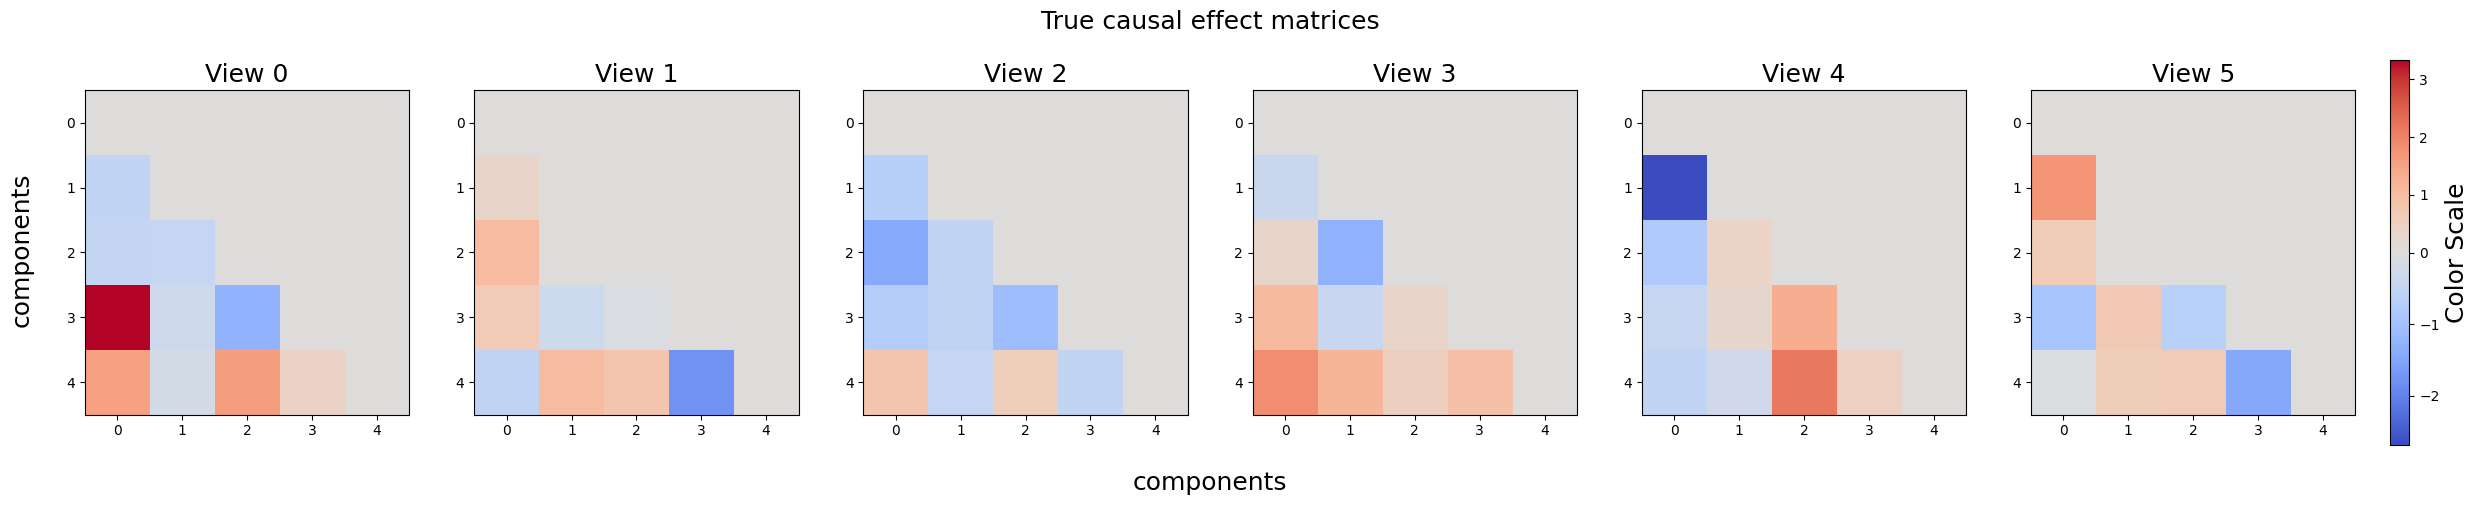

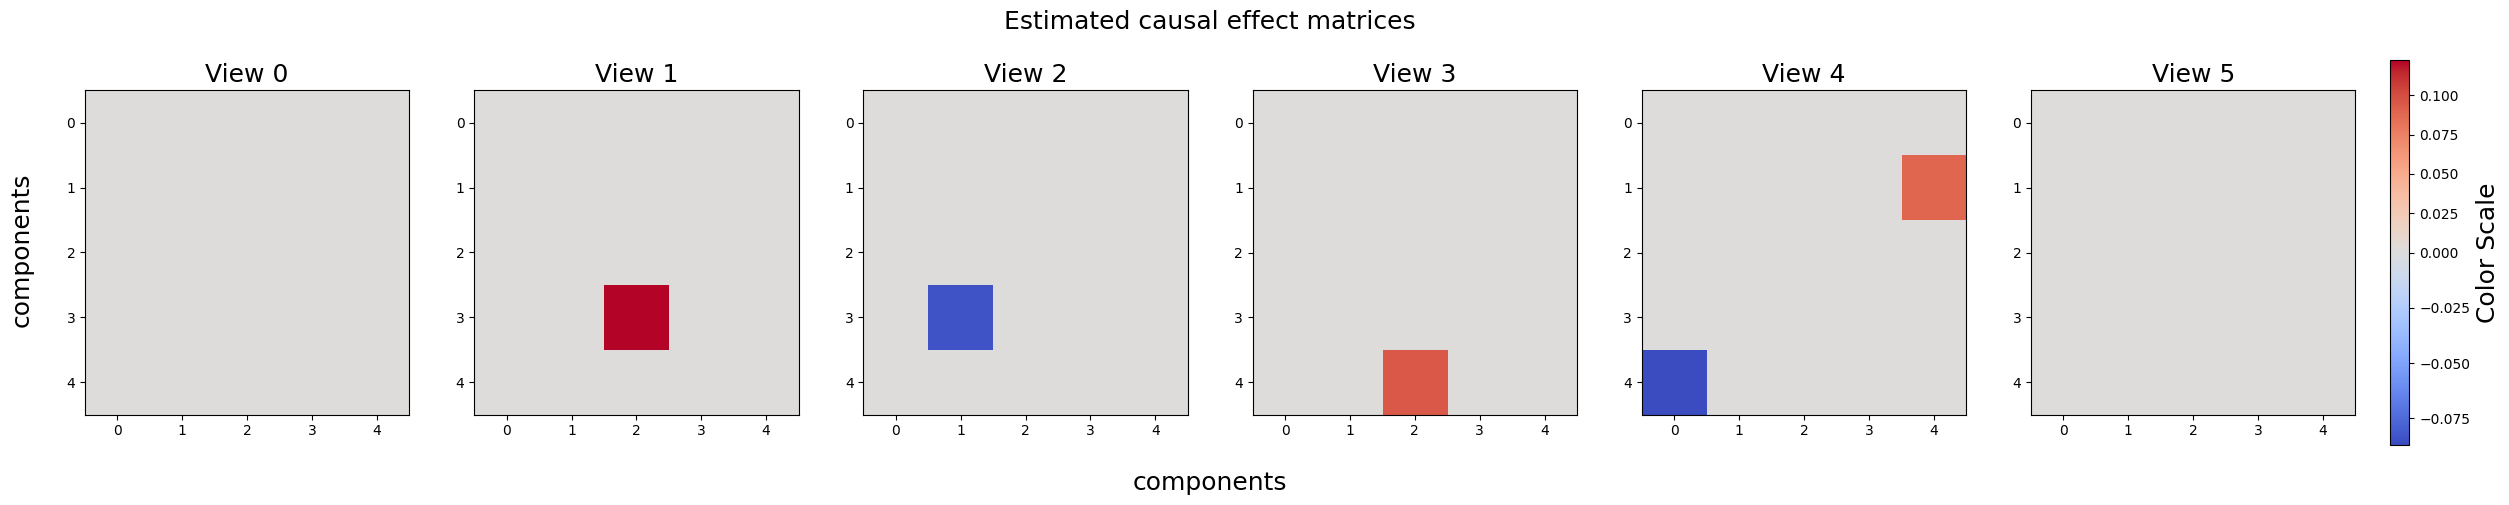

In [43]:
heat_maps_B(B, title_add="True")
heat_maps_B(B_tilde, title_add="Estimated")

# example from github

In [15]:
import pandas as pd
import graphviz
from lingam.utils import print_causal_directions, print_dagc, make_dot

In [16]:
x3 = np.random.uniform(size=1000)
x0 = 3.0*x3 + np.random.uniform(size=1000)
x2 = 6.0*x3 + np.random.uniform(size=1000)
x1 = 3.0*x0 + 2.0*x2 + np.random.uniform(size=1000)
x5 = 4.0*x0 + np.random.uniform(size=1000)
x4 = 8.0*x0 - 1.0*x2 + np.random.uniform(size=1000)
X1 = pd.DataFrame(np.array([x0, x1, x2, x3, x4, x5]).T ,columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])
X1.head()

,x0,x1,x2,x3,x4,x5
0,2.170314,13.715784,3.177400,0.514849,14.439606,9.050394
1,0.993321,4.765985,0.763570,0.077122,7.872322,4.456705
2,3.371414,21.907720,5.537067,0.897963,21.563415,13.713544
3,1.516891,8.951186,2.021043,0.194032,10.291826,7.003242
4,0.586431,5.814702,1.744891,0.163443,3.257884,2.537279


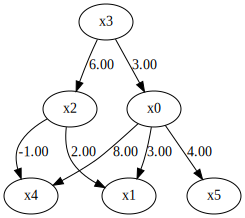

In [17]:
m = np.array([[0.0, 0.0, 0.0, 3.0, 0.0, 0.0],
              [3.0, 0.0, 2.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 6.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [8.0, 0.0,-1.0, 0.0, 0.0, 0.0],
              [4.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

make_dot(m)

In [18]:
x3 = np.random.uniform(size=1000)
x0 = 3.5*x3 + np.random.uniform(size=1000)
x2 = 6.5*x3 + np.random.uniform(size=1000)
x1 = 3.5*x0 + 2.5*x2 + np.random.uniform(size=1000)
x5 = 4.5*x0 + np.random.uniform(size=1000)
x4 = 8.5*x0 - 1.5*x2 + np.random.uniform(size=1000)
X2 = pd.DataFrame(np.array([x0, x1, x2, x3, x4, x5]).T ,columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])
X2.head()

,x0,x1,x2,x3,x4,x5
0,0.377550,4.801758,1.139850,0.024840,2.292762,1.753398
1,4.291207,32.414165,6.594514,0.968780,26.788027,19.827088
2,3.665859,29.980704,6.584130,0.961663,22.093259,16.870098
3,2.554358,19.141650,4.027996,0.606875,16.364102,12.076326
4,1.771353,14.293512,3.032099,0.439221,10.833451,8.622521


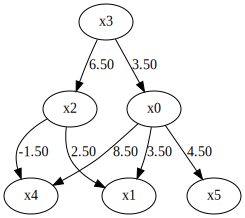

In [19]:
m = np.array([[0.0, 0.0, 0.0, 3.5, 0.0, 0.0],
              [3.5, 0.0, 2.5, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 6.5, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [8.5, 0.0,-1.5, 0.0, 0.0, 0.0],
              [4.5, 0.0, 0.0, 0.0, 0.0, 0.0]])

make_dot(m)

In [20]:
X_list = [X1, X2]

In [22]:
model = lingam.MultiGroupDirectLiNGAM()
model.fit(X_list)

In [31]:
P = np.eye(6)[model.causal_order_]

In [24]:
B = np.array(model.adjacency_matrices_)

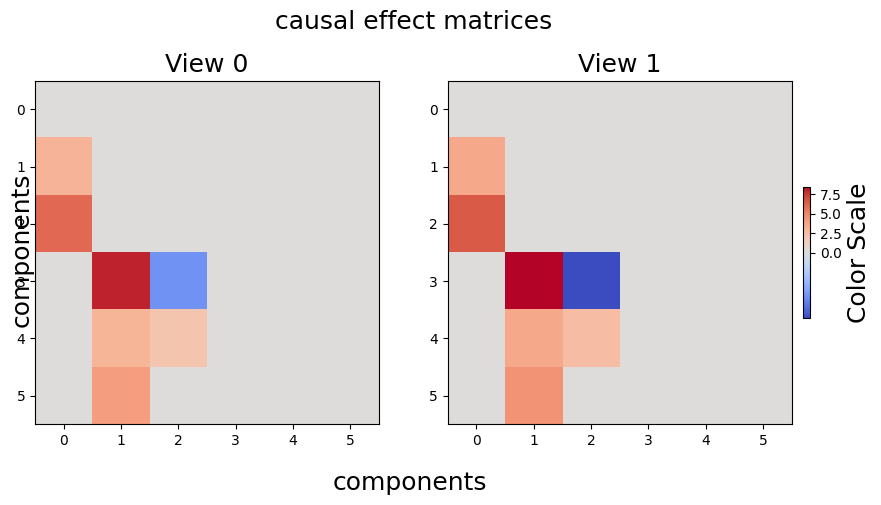

In [32]:
heat_maps_B(P @ B @ P.T)